In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # This code was written in TF 1.12 but should be supported all the way through
# # TF 1.15. Untested in TF 2.0+.
# %tensorflow_version 1.x

# # Download the raw data (only 108 epoch data points, for full dataset,
# # uncomment the second line for nasbench_full.tfrecord).

# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord
# # !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# # Clone and install the code and dependencies.

# !git clone https://github.com/google-research/nasbench
# !pip install ./nasbench

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0  58.7M      0  0:00:33  0:00:33 --:--:-- 57.6M
Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), done.
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py3-none-any.whl size=46788 sha256=bf3a03d96413220b188a729f3adfbbdf9a803edea16a803714ba881fb893a868


In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

In [9]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from source.nasbench.nasbench import api
url = os.path.dirname('__file__')
nasbench = api.NASBench(f"{url + 'source/nasbench/nasbench_full.tfrecord'}")

Loading dataset from file... This may take a few minutes...
Loaded dataset in 121 seconds


# Constant

In [10]:
# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

# Basic usage

In [11]:
# Create an Inception-like module (5x5 convolution replaced with two 3x3
# convolutions).
cell = api.ModelSpec(
    # Adjacency matrix of the module
    matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
            [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
            [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
            [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
            [0, 0, 0, 0, 0, 0, 1],    # max-pool 3x3
            [0, 0, 0, 0, 0, 0, 0]],   # output layer
    # Operations at the vertices of the module, matches order of matrix
    ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])


print(nasbench.is_valid(cell))


# Query this model from dataset, returns a dictionary containing the metrics
# associated with this model.
data = nasbench.query(cell)
print(data['test_accuracy'])
for k, v in data.items():
    print('%s: %s' % (k, str(v)))

True
0.9286859035491943
module_adjacency: [[0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
trainable_parameters: 2694282
training_time: 1154.361083984375
train_accuracy: 1.0
validation_accuracy: 0.9336938858032227
test_accuracy: 0.9286859035491943


# POPOP

In [13]:
def initialize_population( num_individuals, num_variables ):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.
    
    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến
    
    Returns:
    pop -- Ma trận (num_individuals, num_variables) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    # Random giá trị từ 0 -> 4 
    # (đại diện cho 5 operation: "none", "conv1x1", "conv3x3", "maxpool3x3") 
    operation = np.random.randint(4, size=(num_individuals, 4))
    connection = np.random.randint(2, size=(num_individuals, num_variables))
    pop = np.concatenate((operation, connection), axis=1)
    
    return pop

In [14]:
pop = initialize_population(6, 21)
pop

array([[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0],
       [2, 2, 1, 3, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0],
       [0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1],
       [2, 2, 3, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0],
       [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0],
       [2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1]])

In [15]:
def convert_ind_tri(ind, ops_none=None):
    res = np.zeros((7, 7), dtype=int)
    # print(ind)
    k = 0
    for i in range(7):
        for j in range(i + 1, 7):
            res[i][j] = ind[k]
            print(i, j, k, ind[k])
            k += 1
    if ops_none != None:
        res = np.delete(res, ops_none, axis=1)
        res = np.delete(res, ops_none, axis=0)
    return res 

In [17]:
print(convert_ind_tri(pop[0][5:]))
# print(convert_ind_tri(pop[0][5:], [3, 5]))

0 1 0 1
0 2 1 0
0 3 2 0
0 4 3 0
0 5 4 1
0 6 5 1
1 2 6 1
1 3 7 0
1 4 8 1
1 5 9 0
1 6 10 1
2 3 11 0
2 4 12 1
2 5 13 1
2 6 14 0
3 4 15 0
3 5 16 1
3 6 17 1
4 5 18 1
4 6 19 0


IndexError: index 20 is out of bounds for axis 0 with size 20

In [ ]:
def evaluate_arch( ind, epochs, metric ):
    """
    Hàm đánh giá kiến trúc bằng cách truy xuất NATS Bench.
    
    Arguments:
    ind -- Cá thể cần được đánh giá.
    epchs -- Số thự tự epoch đánh giá (12 or 200).
    metric -- Phương pháp đánh giá (test-accuracy, train-accuracy,...).

    Returns:
    value -- Accuracy của cá thể ind tại epoch hp trên một trong 3 dataset (cifar 10, cifar 100, Imagenet16-120).
    """
    
    ### BẮT ĐẦU CODE TỪ ĐÂY ###     
    ops_none = []
    ops = [INPUT]
    for i in range(0, 5):
        if ind[i] == 0:
            ops_none.append(i)
        elif ind[i] == 1:
            ops.append(CONV1X1)
        elif ind[i] == 2:
            ops.append(CONV3X3)
        else:
            ops.append(MAXPOOL3X3)
    ops.append(OUTPUT)
    
    tri = convert_ind_tri(ind[5:], ops_none)
    print(tri)
    print(ops)
    cell = api.ModelSpec(matrix=tri, ops=ops)
    
    if nasbench.is_valid(cell):
        data = nasbench.query(cell, epochs=epochs)
        return data[metric]
    return 0
    ### DỪNG CODE TẠI ĐÂY ###

In [ ]:
acc = evaluate_arch([0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 4, 1, 0, 1, 0, 1, 0, 0, 1, 0], epochs=108, metric='test_accuracy')
acc

[[0 4 0 1]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']


0.8361378312110901

In [ ]:
def evaluate_population( pop, epochs, metric ):
    """
    Hàm đánh giá tất cả cá thể trong quần thể.
    
    Arguments:
    pop -- Quàn thể cần được đánh giá.
    epochs -- Số thự tự epoch đánh giá (12/200).
    metric -- Phương pháp đánh giá (test-accuracy, train-accuracy,...).

    Returns:
    values -- Giá trị của tất cả các cá thể trong quần thể.
    """ 

    ### BẮT ĐẦU CODE TỪ ĐÂY ### 
    values = np.array([evaluate_arch(ind, epochs, metric) for ind in pop])
    
    ### DỪNG CODE TẠI ĐÂY ###
    
    return values

In [ ]:
pop_fitness = evaluate_population(pop, epochs=108, metric='test_accuracy')
print(pop_fitness)

[[0 1 1 0 0 1 0]
 [0 0 1 0 1 1 1]
 [0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
['input', 'maxpool3x3', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'maxpool3x3', 'output']
[[0 1 1 1 0]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'maxpool3x3', 'maxpool3x3', 'output']
[[0 0 0 0 1]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3', 'maxpool3x3', 'output']
[[0 1 1 1 1 1 1]
 [0 0 0 0 1 1 0]
 [0 0 0 1 1 0 1]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'maxpool3x3', 'output']
[[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
['input', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
[[0 0 1 0 0 1 1]
 [0 0 1 1 0 1 0]
 [0 0 0 1 1 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3'

In [ ]:
def better_fitness( fitness_1, fitness_2, maximization=True ):
    """
    Hàm so sánh độ thích nghi của 2 cá thể.
    
    Arguments:
    fitness_1 -- Độ thích nghi của cá thể 1.
    fitness_2 -- Độ thích nghi của cá thể 2.
    maximization -- Biến boolean cho biết bài toán đang giải thuộc dạng tối đa hoá (mặc định) hay không
    
    Returns:
    True nếu fitness_1 tốt hơn fitness_2. Ngược lại, trả về False.
    """
    
    if maximization:
        if fitness_1 > fitness_2:
            return True
    else:
        if fitness_1 < fitness_2:
            return True
        
    return False

In [ ]:
def tournament_selection( pop, pop_fitness, selection_size, tournament_size):
    """
    Hàm chọn lọc cạnh tranh.
    
    Arguments:
    pop -- Quần thể để thực hiện phép chọn lọc.
    pop_fitness -- Mảng 1 chiều chứa giá trị (độ thích nghi) của từng cá thể trong quần thể.
    selection_size -- Số lượng cá thể sẽ được chọn.
    tournament_size -- Kích thước của tournament: Số lượng các cá thể được so sánh với nhau mỗi lần.
    
    Returns:
    selected_indices -- Chỉ số của những cá thể trong quần thể pop được chọn. Chỉ số có thể được lặp lại.
    """
    
    ### BẮT ĐẦU CODE TỪ ĐÂY ### 
    num_individuals = len(pop)
    indices = np.arange(num_individuals)
    selected_indices = []
    
    while len(selected_indices) < selection_size:
        # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể.
        np.random.shuffle(indices)
        
        for i in range(0, num_individuals, tournament_size):
            best_idx = i
            for idx in range(1, tournament_size):
                if better_fitness(pop_fitness[indices[i + idx]], pop_fitness[indices[best_idx]]):
                    best_idx = i + idx
            selected_indices.append(indices[best_idx])

    selected_indices = np.array(selected_indices)

    ### DỪNG CODE TẠI ĐÂY ###
    
    return selected_indices

In [ ]:
def variation( pop ):
    """
    Hàm biến đổi tạo ra các cá thể con.
    
    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """  
    
    ### BẮT ĐẦU CODE TỪ ĐÂY ### 
    num_individuals = len(pop)
    num_parameters = len(pop[0])
    indices = np.arange(num_individuals)
    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    np.random.shuffle(indices)
    offspring = []
    
    for i in range(0, num_individuals, 2):
        idx1 = indices[i]
        idx2 = indices[i+1]
        offspring1 = list(pop[idx1])
        offspring2 = list(pop[idx2])
        
        # Cài đặt phép lai đồng nhất uniform crossover. 
        # Không cần cài đặt đột biến mutation.
        for idx in range(0, num_parameters):
            r = np.random.rand()
            if r < 0.5:
                temp = offspring2[idx]
                offspring2[idx] = offspring1[idx]
                offspring1[idx] = temp 

        offspring.append(offspring1)
        offspring.append(offspring2)


    ### DỪNG CODE TẠI ĐÂY ###
    
    offspring = np.array(offspring)
    return offspring

In [ ]:
def converge_pop_fitness(pop_fitness):
    """
    Hàm kiểm tra hội tụ dựa trên pop_fitness.
    
    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    Nếu tất cả các cá thể có thể fitness bằng nhau thì trả về True, ngược lại trả về False.
    """  
    if np.all(pop_fitness == pop_fitness[0]):
        return True
    return False

In [ ]:
def popop(num_individuals, num_parameters, num_generations, epochs, metric):
    """
    Hàm cài đặt thuật giải di truyền theo các bước P->O->(P+O)->P
    
    Arguments:
    num_individuals -- Số lượng cá thể trong quần thể.
    num_parameters -- Số lượng biến luôn là 6 đối với NATS Bench.
    num_generations -- Số thế hệ thuật toán sẽ chạy.

    Returns:
    In ra quần thể ở thế hệ cuối cùng và giá trị của từng cá thể.
    """ 

    ### BẮT ĐẦU CODE TỪ ĐÂY ### 
    # Khởi tạo quần thể
    pop = initialize_population(num_individuals, num_parameters)
    pop_fitness = evaluate_population(pop, epochs, metric)
    # print("#Gen 0:")
    # print(pop_fitness)
    
    # Sử dụng tournament_size 4 và selection_size là bằng kích thước quần thể
    selection_size = len(pop)
    tournament_size = 4
    i = 0
    while (converge_pop_fitness(pop_fitness) == False):
        # Tạo ra các cá thể con và đánh giá chúng
        offspring = variation(pop)
        offspring_fitness = evaluate_population(offspring, epochs, metric)
        
        # Tạo ra quần thể pool gồm quần thể hiện tại pop và offspring
        pool = np.vstack((pop,offspring))
        pool_fitness = np.hstack((pop_fitness, offspring_fitness))

        # Thực hiện tournament selection trên quần thể pool 
        pool_indices = tournament_selection(pool, pool_fitness, selection_size, tournament_size)
        
        # Thay thế quần thể hiện tại bằng những cá thể được chọn ra từ pool.
        pop = pool[pool_indices, :]
        pop_fitness = pool_fitness[pool_indices]
        print("#Gen {}:".format(i+1))
        i+=1
        print(pop_fitness)
        print(pop)

        # Đẩy fitness cao nhất của quần thể ở thế hệ hiện tại vào best_fitness_arr
        best_fitness = np.amax(pop_fitness)
        best_fitness_arr.append(best_fitness)

        # Lấy ra cá thể có fitness tốt nhất trong quần thể ở thế hệ hiện tại
        best_arch_index = np.where(pop_fitness == np.amax(pop_fitness))
        best_arch = pop[best_arch_index[0][0]]

        # Truy xuất test accuracy của cá thể tốt nhất trong quần thể ở thế hệ hiện tại trên cifar10, cifar100, imagenet
        # test_acc_cifar_10.append(evaluate_arch(best_arch, 'cifar10', hp=200, metric='test-accuracy'))
        # test_acc_cifar_100.append(evaluate_arch(best_arch, 'cifar100', hp=200, metric='test-accuracy'))
        # test_acc_imagenet.append(evaluate_arch(best_arch, 'ImageNet16-120', hp=200, metric='test-accuracy'))
      
        if (converge_pop_fitness(pop_fitness)):
            break
    ### DỪNG CODE TẠI ĐÂY ###
    print("#Result:")
    print(pop)
    print(pop_fitness)
    
    
    # print(best_arch_index[0][0])
    # return pop[best_arch_index[0][0]]

In [ ]:
np.random.seed(1)
num_parameters = 21 #Luôn luôn là 21 đối với NAS Bench 101
num_individuals = 32
num_generations = 20
best_fitness_arr = []
epochs = 108
metric = 'test_accuracy'
popop(num_individuals, num_parameters, num_generations, epochs=epochs, metric=metric)

[[0 1 0 0 0 0]
 [0 0 1 1 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'output']
[[0 0 0 1 0]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'maxpool3x3', 'maxpool3x3', 'output']
[[0 1 0 0 0 1 0]
 [0 0 1 0 1 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'maxpool3x3', 'output']
[[0 0 0 0 0 1 1]
 [0 0 0 1 1 0 0]
 [0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']
[[0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 1 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
['input', 'maxpool3x3', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
[[0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 0 1 0]
 [0 0 0 

Text(0.5, 1.0, 'popsize = 32')

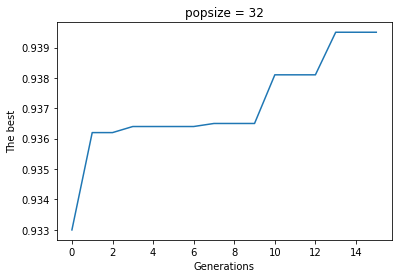

In [ ]:
plt.plot(best_fitness_arr)
plt.xlabel("Generations")
plt.ylabel("The best")
plt.title("popsize = " + str(num_individuals))

In [ ]:
mean_the_best = []
for i in range(10):
    np.random.seed(i)
    num_parameters = 21 #Luôn luôn là 21 đối với NATS Bench
    num_individuals = 32
    num_generations = 312
    best_fitness_arr = []
    epochs = 108
    metric = 'test_accuracy'
    popop(num_individuals, num_parameters, num_generations, epochs=epochs, metric=metric)
    mean_the_best.append(best_fitness_arr)

Streaming output truncated to the last 5000 lines.
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3', 'maxpool3x3', 'maxpool3x3', 'output']
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']
[[0 1 0 0 1 1]
 [0 0 1 0 0 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']
[[0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'maxpool3x3', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'output']
[[0 1 1 1]
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 0]]
['input', 'maxpool3x3', 'maxpool3x3', 'output']
[[0 0 1 1]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
[[0 0 0 0 0 0 1]
 [0 0 0 1 1 0 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 0 1 1]
 [0 0 

In [ ]:
#Lấy số thế hệ lớn nhất trong các runs
max_length = 0
for i in range(len(mean_the_best)):
    length = len(mean_the_best[i])
    max_length = max(max_length, length)
max_length

23

In [ ]:
#Thêm giá trị còn thiếu cho các the best để có thể tính trung bình và độ lệch chuẩn
for i in range(len(mean_the_best)):
    length = len(mean_the_best[i])
    value = mean_the_best[i][length - 1]
    for _ in range (max_length - length):
        mean_the_best[i].append(value)

In [ ]:
mean_the_best = np.array(mean_the_best)
mean_the_best = mean_the_best.mean(axis=0)
std_the_best = mean_the_best.std(axis=0)
print(mean_the_best)
print(std_the_best)

[0.93470554 0.93647836 0.93761017 0.93896233 0.9394431  0.93999398
 0.94036458 0.94055489 0.94055489 0.94087541 0.94117589 0.9413061
 0.9413061  0.9413061  0.9413061  0.9413061  0.94153647 0.94153647
 0.94153647 0.94153647 0.94153647 0.94153647 0.94153647]
0.001777856663294118


Text(0.5, 1.0, 'epochs = 108 (10 runs) popsize = 32')

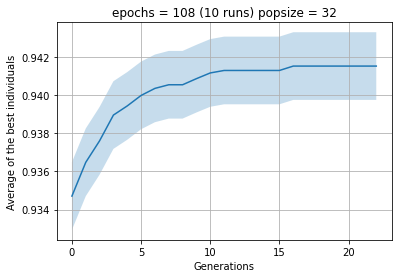

In [ ]:
generations_arr = np.arange(max_length)
plt.plot(generations_arr, mean_the_best)
plt.fill_between(generations_arr, mean_the_best + std_the_best, mean_the_best - std_the_best, alpha=0.25)
plt.grid()
plt.xlabel("Generations")
plt.ylabel("Average of the best individuals")
plt.title("epochs = " + str(epochs) + " (10 runs) popsize = " + str(num_individuals))